The goal of my notebook is to find a way to extract rationales (= justification a prediction) from data classified as "toxic".

To do so, according to peer-reviewed methods, there are several options:

1. Use the self-attention scores of the classifier as token importance (see Leo's work)
2. Perturb or back-prop once the model is trained (IG, GradCAM, LIME, SHAP) -> **huge token-level noise & very slow for large dataset**
3. Hard-selection "rationalizing" models (generator picks a sparse subset and predictor uses only it) -> **HEAVY!!! also generator often drops synthactic glue -> low recall**
4. Supervised token-label models (fine-tune BERT with a second token-level BiLSTM/CRF head on HateXplain rationales) -> **fast, good F1, needs faithfulness regulariser (sparse annotion risk!!)**
5. Masked-rational prediction (use an auxiliary loss: mask predicted rationale, ask model to reconstruct class from only those tokens -> encourages necessity & sufficiency) -> **robust F1, needs 2 forward passes per step**
6. Semi-/Self-training (Teacher-student) -> Train on gold spans, predict on unlabelled data, keep high-confidence spans, retrain -> **quality hinges on initial extractor, risk of error amplification BUT works well when bootstrapped from a strong supervised extractor**
7. LLM chain-of-thought extraction (prompt GPT-3.5/4 to highlight toxic words) -> **good human plausibility BUT license issues**

### What makes a good rationale extractor:
- faithfulness (if we delete the selected tokens, the model’s prediction should flip (comprehensiveness) and if we keep only the tokens, the prediction should stay (sufficiency))
- granularity (need word- or sub-word spans, not whole sentences)
- plausibility (human annotators should agree that the highlighted words look toxic)
- training signal available (use HateXplain rationales labels)

I will try 4 (for extractor) + 5 + 6 (and maybe 7 if i have time) => use a supervised multi-task BERT span-tagger (token classification head) regularised with a HardKuma selector, backed up by Integrated Gradients for sanity-checking. The steps are as follows:

### 1. **SUPERVISED EXTRACTOR (token tagging):** Fine-tune multi-task BERT-base span-tagger with 2 heads:
- sentence-level classification head (toxic vs. non-toxic binary classification) (cross-entropy)
- token-level rationale tags (sigmoid for each sub-token)

Use a multi-objective loss function to train the rationale extractor + classifier at the same time

+ & use HardKuma = differentiable mechanism for selecting discrete tokens (like specific words) in a sentence while still allowing backpropagation. It was introduced by Bastings et al. (2020) in “Interpretable Neural Predictions with Differentiable Binary Variables”.

#### Evaluation & calibration:

- Hold out 10 % of HateXplain for token-level metrics (IOU-F1, comprehensiveness, sufficiency – ERASER toolkit) 
ACL Anthology
- Choose the probability threshold that maximises dev token-F1; typical ≈ 0.4.

#### Generalisation check
Test on the external Toxic-Span (SemEval-2021) set; you should still get ≈ 0.46 F1 (Multi-task CRF baseline) 

### 2. **CONFIDENCE-FILTERED SELF-TRAINING:** Run the extractor on the generated posts (from Melina's generator). 

graph TD
  A[Generated post] --> B(Rationale extractor)
  B -->|mask| C{Toxic tokens}
  C --> D[Homoglyph + leet transform]
  A -->|context| E[Untouched tokens]
  D --> F{Re-assemble text}
  E --> F


=> Report token-level F1, Sufficiency & Comprehensiveness (ERASER metrics)

## Implementation tips:

1. Sub-token aggregation - aggregate logits with max per original token to avoid partial masking.

2. Sparsity without recall loss - tune λ_len s.t. mean span length ≈ 25 % of tokens; lower hurts precision, higher drops recall.

3. Stop-word whitelist - never transform stop-words even if tagged (keeps syntax readable).

4. Version control - export masks to JSON; downstream augmentation becomes a pure text-edit, reproducible for audits.

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import math
import requests
import random
from collections import Counter, defaultdict
from typing import Optional, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, get_linear_schedule_with_warmup, EarlyStoppingCallback, pipeline
from transformers import AutoModel, PreTrainedTokenizerBase
from pyleetspeak.LeetSpeaker import LeetSpeaker

In [241]:
SEED = 13
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {DEVICE}")

device: cuda


# 1) LOAD DATASET

In [ ]:
# load data
data_classes_two = np.load('../Data/classes_two.npy', allow_pickle=True)
data_classes = np.load('../Data/classes.npy', allow_pickle=True)

with open('../Data/dataset.json', 'r') as f:
    dataset = json.load(f)

with open('../Data/post_id_divisions.json', 'r') as f:
    split_ids = json.load(f)


examples_binary = [
    (" ".join(dataset[k]['post_tokens']), label)
    for k, label in zip(dataset.keys(), data_classes_two)
]

In [243]:
rationales = [
    (dataset[k]['rationales'])
    for k in dataset.keys()
]

posts = [
    (dataset[k]['post_tokens'])
    for k in dataset.keys()
]

print(len(posts))
print(len(rationales))
print(posts[3])
print(rationales[3])

20148
20148
['<user>', 'i', 'am', 'bit', 'confused', 'coz', 'chinese', 'ppl', 'can', 'not', 'access', 'twitter', 'thn', 'how', 'this', 'ching', 'chong', 'using', 'it', 'i', 'think', 'he', 'pakistani', '🤔', '🤔', '🤔']
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


# 2) PREPROCESSING

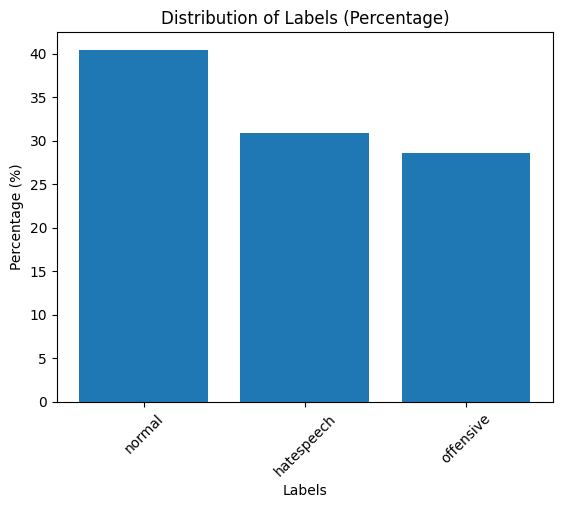

In [244]:
examples = []

for k, v in dataset.items():
    text = " ".join(v['post_tokens']) 
    
    # Use majority vote to decide the label
    if 'annotators' in v and v['annotators']:
        labels = [ann['label'] for ann in v['annotators']] # Get labels from annotators
        label_counts = Counter(labels) 
        majority_label = label_counts.most_common(1)[0][0] # Get the most common label
        examples.append((text, majority_label))

label_counts = Counter(label for _, label in examples)
total = sum(label_counts.values())
label_percentages = {label: (count / total) * 100 for label, count in label_counts.items()}

plt.bar(label_percentages.keys(), label_percentages.values())
plt.xlabel('Labels')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Labels (Percentage)')
plt.xticks(rotation=45)
plt.show()

In [270]:
# RESOLVE DISAGREEMENT BETWEEN ANNOTATORS

def compute_annotator_disagreement(dataset, verbose=False, return_top_n=0, plot=False):
    """
    Compute the number of unique labels assigned by annotators for each post,
    and optionally plot disagreement distribution.
    
    Args:
        dataset (dict): Loaded JSON dataset
        verbose (bool): Print summary stats
        return_top_n (int): If >0, return top N most disagreed examples
        plot (bool): If True, plot a histogram of disagreement levels

    Returns:
        disagreement_stats (list of tuples): (post_id, disagreement_count, label_counter)
        top_disagreements (optional): top N posts with highest disagreement
    """
    disagreement_stats = []

    for post_id, content in dataset.items():
        labels = [ann['label'] for ann in content.get('annotators', [])]
        label_counter = Counter(labels)
        disagreement_count = len(label_counter)
        disagreement_stats.append((post_id, disagreement_count, label_counter))

    if verbose:
        total = len(disagreement_stats)
        unanimous = sum(1 for _, c, _ in disagreement_stats if c == 1)
        mild_disagreement = sum(1 for _, c, _ in disagreement_stats if c == 2)
        full_disagreement = sum(1 for _, c, _ in disagreement_stats if c >= 3)

        print(f"Total examples: {total}")
        print(f"Unanimous (all annotators agree): {unanimous} ({unanimous/total:.2%})")
        print(f"Two-label disagreement: {mild_disagreement} ({mild_disagreement/total:.2%})")
        print(f"Three-label disagreement: {full_disagreement} ({full_disagreement/total:.2%})")

    if plot:
        disagreement_counts = [c for _, c, _ in disagreement_stats]
        count_dist = Counter(disagreement_counts)
        plt.bar(count_dist.keys(), count_dist.values(), color='gray')
        plt.xlabel("Number of unique labels (Disagreement level)")
        plt.ylabel("Number of posts")
        plt.title("Annotator Disagreement Distribution")
        plt.xticks([1, 2, 3])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if return_top_n > 0:
        top_disagreements = sorted(disagreement_stats, key=lambda x: -x[1])[:return_top_n]
        return disagreement_stats, top_disagreements

    return disagreement_stats

def resolve_disagreements_custom(dataset, disagreement_stats):
    resolved = []
    counter_unanimous = 0
    counter_hatespeech = 0
    counter_off_normal = 0
    counter_skipped = 0

    for post_id, disagreement, label_counts in disagreement_stats:
        if disagreement == 3:
            counter_skipped += 1
            continue  # skip level 3 disagreements

        text = " ".join(dataset[post_id]['post_tokens'])
        labels = list(label_counts.elements())
        label_set = set(label_counts.keys())

        # Case 1: unanimous
        if disagreement == 1:
            counter_unanimous += 1
            resolved_label = labels[0]

        # Case 2: offensive vs hatespeech → resolve as hatespeech
        elif disagreement == 2 and label_set == {"offensive", "hatespeech"}:
            counter_hatespeech += 1
            resolved_label = "hatespeech"

        # Case 3: normal vs offensive or normal vs hatespeech → majority
        else:
            counter_off_normal += 1
            resolved_label = Counter(labels).most_common(1)[0][0]

        resolved.append((text, resolved_label))

    print(f"Unanimous: {counter_unanimous}, Offensive vs Hatespeech: {counter_hatespeech}, Normal vs Other: {counter_off_normal}, Skipped (3-label): {counter_skipped}")
    return resolved




disagreement_stats, top_disagreements = compute_annotator_disagreement(dataset, verbose=True, return_top_n=5, plot=False)


resolved_examples_custom = resolve_disagreements_custom(dataset, disagreement_stats)

Total examples: 20148
Unanimous (all annotators agree): 9845 (48.86%)
Two-label disagreement: 9384 (46.58%)
Three-label disagreement: 919 (4.56%)
Unanimous: 9845, Offensive vs Hatespeech: 3916, Normal vs Other: 5468, Skipped (3-label): 919


In [246]:
MERGE_MODE = "union" # other possibilities: "majority" -> but may drop rare buzt valid toxic terms / else: intersection (POOR COVERAGE, TOO STRICT!!!!!!!!!!)

def merge_rationales(masks, n_tokens, mode="union"):
    """
    masks    : List[List[int]] (length 0–3, possibly wrong sizes)
    n_tokens : int  = len(post['post_tokens'])
    Returns   : merged mask (list[int]) or None if no valid annotator
    """
    # Keep only masks whose length matches the post
    arrs = [np.array(m) for m in masks if len(m) == n_tokens]

    if len(arrs) == 0:
        return None                      # no reliable annotator mask

    if mode == "union":
        merged = np.bitwise_or.reduce(arrs)
    elif mode == "majority":
        thr = (len(arrs) + 1) // 2       # majority among remaining annotators
        merged = (np.sum(arrs, axis=0) >= thr).astype(int)
    else:                                # "intersection"
        merged = np.bitwise_and.reduce(arrs)
    return merged.tolist()



### --------- NEW VERSION ONLY CONSIDERS HATESPEECH --------- ###


def preprocess_record(post):
    text = " ".join(post["post_tokens"])
    labels = [ann["label"] for ann in post["annotators"]]
    majority_label = Counter(labels).most_common(1)[0][0]

    # Skip "offensive" posts entirely
    if majority_label == "offensive":
        return None

    n_tokens = len(post["post_tokens"])
    merged_rat = None

    if majority_label == "hatespeech" and post.get("rationales"):
        merged_rat = merge_rationales(post["rationales"], n_tokens, mode=MERGE_MODE)

    bin_label = "toxic" if majority_label == "hatespeech" else "non-toxic"
    return text, bin_label, merged_rat

records = {pid: preprocess_record(post) for pid, post in dataset.items()}


In [ ]:
# combine hatespeech and offensive as toxic non-toxic


data_binary = [
    (text, "toxic") if label == "hatespeech" else (text, "non-toxic")
    for text, label in resolved_examples_custom
    if label in {"hatespeech", "normal"}
]

CKPT_DIR = "../Models/hardkuma_ckpt"


print(f"length of data_binary: {len(data_binary)}")
print(data_binary[106][0])

length of data_binary: 15430
this nigger just saved the uk


In [271]:
# EXTRACTION OF DATA LABELED AS TOXIC


toxic_data = [post for post, label in data_binary if label == "toxic"]

print(f"Number of toxic posts: {len(toxic_data)}")


Number of toxic posts: 7616


the HardKuma architecture has 2 tightly-coupled parts trained jointly:

- Generator: Pick a minimal set of tokens that makes the text look toxic.
- Predictor: Decide whether a post is toxic given only those selected tokens.

Need to train this model also using non-toxic content even if the model is only used to predict rationales on toxic data at inference time, otherwise:
- the predictor will be blocked thinking "everything is toxic" so the generator receives no pressure to isolate trigger words
- since the predictor is happy regardless, length vs. continuity regularisers fight each other => get masks that highlight nothing (all 0s) or everything (all 1s)
- the model never saw what non-toxic language looks like, so any unfamiliar wording might be (falsely) highlighted => poor generalisation

In [249]:
# HARDKUMA

# -------------------------------------------------------------
# HardKuma distribution utilities (Bastings et al., 2020)
# -------------------------------------------------------------

class HardKumaSampler(nn.Module):
    """Samples a binary (0/1) mask via the HardKuma re‑parameterisation.

    Given shape (alpha) and rate (beta) > 0, the sampler draws a sample z in
    the open interval (0, 1) during the forward pass, then hard‑rounds it to
    {0,1} while using the soft value for gradient flow (straight‑through).
    """

    def __init__(self, eps: float = 1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, alpha: torch.Tensor, beta: torch.Tensor, hard: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return (z_hard, z_soft).

        z_soft is the continuous sample; z_hard is detached to be exactly 0/1
        but uses z_soft in the backward pass (straight‑through).
        """
        # Sample u ~ Uniform(0, 1)
        u = torch.rand_like(alpha)
        v = (1 - u.pow(1.0 / beta)).clamp(self.eps, 1 - self.eps)
        z_soft = (1 - v.pow(1.0 / alpha)).clamp(self.eps, 1 - self.eps)

        if hard:
            z_hard = (z_soft > 0.5).float()
            # Straight‑through gradient: replace hard with soft in backward
            z_hard = z_hard.detach() - z_soft.detach() + z_soft
        else:
            z_hard = z_soft
        return z_hard, z_soft

# -------------------------------------------------------------
# Rationale Generator + Predictor model
# -------------------------------------------------------------
class HardKumaRationaleModel(nn.Module):
    """Generator‑Predictor architecture for rationale extraction.

    * Generator: produces binary mask z over tokens via HardKuma.
    * Predictor: applies BERT to the masked input and predicts toxicity.
    """

    def __init__(self, bert_name: str = "bert-base-uncased", max_len: int = 128):
        super().__init__()
        self.max_len = max_len
        self.bert = AutoModel.from_pretrained(bert_name)
        hidden_size = self.bert.config.hidden_size

        # Generator head → 2 positives (alpha, beta) per token
        self.gen_head = nn.Linear(hidden_size, 2)
        self.hardkuma = HardKumaSampler()

        # Classifier head on [CLS]
        self.cls_head = nn.Linear(hidden_size, 1)

    # ------------------------------------------------------------------
    # Mask application helper
    # ------------------------------------------------------------------
    @staticmethod
    def apply_mask(embeddings: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """Element‑wise multiply embeddings by z (shape: batch × seq_len × 1)."""
        return embeddings * z.unsqueeze(-1)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        rationale_labels: Optional[torch.Tensor] = None,
        lambda_len: float = 1.0,
        lambda_cont: float = 1.0,
        lambda_sup: float = 1.0,
    ) -> dict:
        # BERT contextual embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden = outputs.last_hidden_state  # (B, L, H)

        # Generator: predict alpha, beta > 0 via softplus
        alpha_beta = F.softplus(self.gen_head(hidden)) + 1e-4  # (B, L, 2)
        alpha, beta = alpha_beta[..., 0], alpha_beta[..., 1]

        z, z_soft = self.hardkuma(alpha, beta)  # (B, L)
        masked_hidden = self.apply_mask(hidden, z)

        # Predictor on masked sequence (take [CLS])
        cls_repr = masked_hidden[:, 0, :]
        logits = self.cls_head(cls_repr).squeeze(-1)  # (B,)

        # ----------------------------------------------------------
        # Loss components
        # ----------------------------------------------------------
        out = {"logits": logits, "z_hard": z, "z_soft": z_soft}

        if rationale_labels is not None:
            # Binary cross‑entropy for token supervision
            sup_loss = F.binary_cross_entropy(z_soft, rationale_labels.float(), reduction="none")
            sup_loss = (sup_loss * attention_mask).sum() / attention_mask.sum()
            out["sup_loss"] = sup_loss * lambda_sup
        else:
            out["sup_loss"] = 0.0 * logits.sum()

        # Length regulariser: encourage sparse mask
        avg_len = z_soft.mean()
        len_loss = avg_len * lambda_len
        out["len_loss"] = len_loss

        # Continuity regulariser: encourage contiguous spans
        diff = torch.abs(z_soft[:, 1:] - z_soft[:, :-1]) * attention_mask[:, 1:]
        cont_loss = diff.mean() * lambda_cont
        out["cont_loss"] = cont_loss

        # Classification loss must be computed outside (BCEWithLogitsLoss)
        return out

# -------------------------------------------------------------
# Training step utility
# -------------------------------------------------------------
def training_step(batch, model, criterion, lambdas):
    # unpack & move to device
    input_ids, attn_mask, labels, rat_labels = (t.to(DEVICE) for t in batch)

    out = model(
        input_ids=input_ids,
        attention_mask=attn_mask,
        rationale_labels=rat_labels,
        lambda_len=lambdas["len"],
        lambda_cont=lambdas["cont"],
        lambda_sup=lambdas["sup"],
    )

    sup_loss_raw = out["sup_loss"]                     # (scalar per sample)
    has_mask     = (rat_labels.sum(dim=1) > 0).float()
    sup_loss     = (sup_loss_raw * has_mask).sum() / has_mask.sum().clamp(min=1)

    clf_loss   = criterion(out["logits"], labels)
    total_loss = clf_loss + sup_loss + out["len_loss"] + out["cont_loss"]
    out.update({"clf_loss": clf_loss, "total_loss": total_loss})

    # Cast labels to int **once** for metric calculation later
    labels_long = labels.long()
    return out, labels_long


bert-base-uncased is a pretrained transformer model published in the original BERT paper (uncased = converts all input text to lowercase + removes accents and casing distinctions) --> fast tokenisers, mature implementations, and widespread usage in toxic content classification benchmarks + Matches the token distribution in HateXplain

/!\ HateBERT only if targeting in-domain toxic slang, especially from Reddit or Gab but may overfit to source domain (less general) /!\

In [250]:
# dataset wrapper

class HateXplainDataset(Dataset):
    """
    Each item from `data_binary` is a (text, label_str) tuple where
        label_str ∈ {"toxic", "non-toxic"}.
    Optionally supply `rat_masks` - a list (same length) where each element is
    either:
        * list[int] of 0/1 at **word** level  (toxic post with annotation)
        * None                                (toxic post w/out annot OR non-toxic)
    The class:
        • tokenises with HF tokenizer
        • aligns word-level rationale to WordPiece level
        • outputs (input_ids, attention_mask, label_float, rat_mask, sup_weight)
    """

    LABEL_MAP = {"non-toxic": 0.0, "toxic": 1.0}

    def __init__(self, pairs, ratm, tokenizer, max_len):
        self.pairs, self.ratm = pairs, ratm
        self.tok, self.max_len = tokenizer, max_len

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        text, lbl = self.pairs[idx]
        label = torch.tensor(self.LABEL_MAP[lbl])
        enc = self.tok(text, truncation=True, padding="max_length",
                       max_length=self.max_len, return_offsets_mapping=True,
                       return_tensors="pt")
        ids  = enc["input_ids"].squeeze(0)
        attn = enc["attention_mask"].squeeze(0)
        offs = enc["offset_mapping"].squeeze(0)

        # ----- build rationale mask -----
        if self.ratm[idx] is not None:            # toxic with annotation
            word_mask = torch.tensor(self.ratm[idx], dtype=torch.float)
            wp2word = (offs[:,0]==0).cumsum(0)-1
            wp2word[wp2word < 0] = -1
            wp2word[wp2word >= len(word_mask)] = -1
            sel   = wp2word >= 0
            rmask = torch.zeros_like(ids, dtype=torch.float)
            rmask[sel] = word_mask[wp2word[sel]]
        else:
            rmask = torch.zeros_like(ids, dtype=torch.float)

        return ids, attn, label, rmask

In [251]:
# split data -> train / val + test set

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

records = {pid: out for pid, post in dataset.items()
           if (out := preprocess_record(post)) is not None} # we skip posts that were removed due to 'offensive'

def make_subset(id_list):
    texts, labels, ratm = [], [], []
    for pid in id_list:
        if pid not in records:
            continue  # skip posts that were removed due to 'offensive'
        text, lab, rat = records[pid]
        texts.append(text)
        labels.append(lab)
        ratm.append(rat)
    return list(zip(texts, labels)), ratm


train_pairs, train_rats = make_subset(split_ids["train"])
valid_pairs, valid_rats = make_subset(split_ids["val"])
test_pairs, test_rats = make_subset(split_ids["test"])

In [252]:
from collections import Counter

print("Train label distribution:", Counter([label for _, label in train_pairs]))
print("Valid label distribution:", Counter([label for _, label in valid_pairs]))
print("Test  label distribution:", Counter([label for _, label in test_pairs]))


Train label distribution: Counter({'non-toxic': 6251, 'toxic': 4748})
Valid label distribution: Counter({'non-toxic': 781, 'toxic': 593})
Test  label distribution: Counter({'non-toxic': 782, 'toxic': 594})


In [210]:
len(train_pairs), len(valid_pairs), len(test_pairs)

(10999, 1374, 1376)

In [276]:
def collate(batch):
    return tuple(torch.stack(items) for items in zip(*batch))

BATCH_SZ = 16
MAX_LEN = 128

train_ds = HateXplainDataset(train_pairs, train_rats, tokenizer, MAX_LEN)
val_ds   = HateXplainDataset(valid_pairs,  valid_rats,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SZ,
                          shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SZ,
                          shuffle=False, collate_fn=collate)



model = HardKumaRationaleModel(max_len=MAX_LEN).to(DEVICE)

pos_weight = torch.tensor([len([l for _,l in train_pairs if l=="non-toxic"]) /
                      len([l for _,l in train_pairs if l=="toxic"])],
                     device=DEVICE) # to balance classes -> class weight
clf_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optim = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
lambdas = {"len": 3.0,  # stronger sparsity -> TUNE!!!!
           "cont": 2.0,
           "sup": 1.0}   # set to 0 if no supervised labels at all


## Finding rationales in generated data using the trained model

In [ ]:
# LOAD MODEL

# 3.1  Rebuild tokenizer exactly as before

CKPT_DIR = "../Models/hardkuma_ckpt"

tokenizer = AutoTokenizer.from_pretrained(CKPT_DIR)

# 3.2  Read metadata, recreate the architecture skeleton
meta  = json.load(open(f"{CKPT_DIR}/training_meta.json"))
model = HardKumaRationaleModel(
            bert_name = meta["bert_model_name"],
            max_len   = meta["max_len"]
        )
model.load_state_dict(torch.load(f"{CKPT_DIR}/pytorch_model.bin",
                                 map_location=DEVICE))
model.to(DEVICE).eval()

HardKumaRationaleModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
# load generated data

toxic_path = "../augmented_data/combined-toxic.csv"
generated_toxic_posts = pd.read_csv(toxic_path)["text"].tolist()

non_toxic_path = "../augmented_data/combined-non-toxic.csv" 
generated_non_toxic_posts = pd.read_csv(non_toxic_path)["text"].tolist()

print(len(generated_toxic_posts))
print(len(generated_non_toxic_posts))

206
152


In [284]:
def find_rationales(texts, model, tokenizer, max_len=128, batch_size=16):
    """
    Args:
        texts      : List[str] toxic posts (e.g. from CSV)
        model      : trained HardKumaRationaleModel (already loaded and .eval())
        tokenizer  : tokenizer matching the model
        max_len    : max token length (same as used during training)
        batch_size : batch size for inference

    Returns:
        List[Dict] — for each text:
            {
              'tokens':            List[str] (WordPiece tokens),
              'rationale_mask':    List[int] (0/1, aligned with tokens),
              'rationale_tokens':  List[str] (non-special tokens where mask == 1)
            }
    """
     # -- dataset: wrap each string with a dummy "toxic" label
    dataset = HateXplainDataset(
                [(t, "toxic") for t in texts],   # pairs (text, label)
                ratm=[None] * len(texts),        # no human rationales
                tokenizer=tokenizer,
                max_len=max_len
             )
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=collate)

    results = []
    model.eval()
    with torch.no_grad():
        for ids, attn, _, _ in loader:           # 4-tuple per collate
            ids, attn = ids.to(DEVICE), attn.to(DEVICE)
            z_hard    = model(ids, attn)["z_hard"].cpu()   # (B, L)

            for wp_ids, wp_mask, z in zip(ids.cpu(),
                                          attn.cpu(),
                                          z_hard):
                tokens = tokenizer.convert_ids_to_tokens(wp_ids.tolist())
                rationale_tokens = [
                    tok for tok, m, zh in zip(tokens, wp_mask, z)
                    if m == 1 and zh == 1
                       and tok not in ("[CLS]", "[SEP]", "[PAD]")
                ]
                results.append(
                    dict(tokens=tokens,
                         rationale_mask=z.int().tolist(),
                         rationale_tokens=rationale_tokens)
                )
    return results




rationale_outputs = find_rationales(generated_toxic_posts, model=model, tokenizer=tokenizer, max_len=128 , batch_size=16)


## Homoglyph / leet substitution on rationales

Because rationale_mask aligns 1-to-1 with WordPiece tokens, you can now:

1) reconstruct each contiguous span (idi ##0 ##t → idi0t),

2) substitute only those spans with your homoglyph/leet mapping,

3) re-join the sentence (keeping everything else intact).

In [285]:
# Turn generated posts into the same “pair + mask” format

# 2.1  toxic
gen_tox_pairs = [(text, "toxic") for text in generated_toxic_posts]
gen_tox_rats  = [out["rationale_mask"] for out in rationale_outputs]

# 2.2  non-toxic  (mask = None → will become zeros)
gen_nontox_pairs = [(t, "non-toxic") for t in generated_non_toxic_posts]
gen_nontox_rats  = [None] * len(gen_nontox_pairs)

In [286]:
# split generated data 8:1:1 and merge with original splits

def split(lst, rats, train_p=0.8, val_p=0.1):
    idx = np.random.permutation(len(lst))
    n_train = int(train_p*len(lst)); n_val = int(val_p*len(lst))
    tr, va, te = idx[:n_train], idx[n_train:n_train+n_val], idx[n_train+n_val:]
    return ([lst[i] for i in tr], [rats[i] for i in tr],
            [lst[i] for i in va], [rats[i] for i in va],
            [lst[i] for i in te], [rats[i] for i in te])

(t_tr, r_tr, t_va, r_va, t_te, r_te) = split(gen_tox_pairs, gen_tox_rats, 1.0)
(nt_tr, nr_tr, nt_va, nr_va, nt_te, nr_te) = split(gen_nontox_pairs, gen_nontox_rats, 1.0)

print(len(test_pairs))

train_pairs += t_tr + nt_tr;    train_rats += r_tr + nr_tr
valid_pairs += t_va + nt_va;    valid_rats += r_va + nr_va
test_pairs  += t_te + nt_te;    test_rats  += r_te + nr_te

print(len(test_pairs))

1376
1376


In [287]:
def build_homoglyph_map():
    url = "https://www.unicode.org/Public/security/latest/confusables.txt" 
    response = requests.get(url) # Fetch the confusables data
    raw_text = response.text     # Get the text content

    homoglyph_map = defaultdict(list) 

    for line in raw_text.splitlines():
        if line.startswith('#') or not line.strip(): # Skip comments and empty lines
            continue
        try:
            src_hex, target_hex, *_ = line.split(';') # 
            src_char = chr(int(src_hex.strip(), 16))
            target_chars = ''.join([chr(int(h, 16)) for h in target_hex.strip().split()])

            # We only want visually similar substitutions that map to 1 character
            if len(src_char) == 1 and len(target_chars) == 1:
                ascii_base = target_chars.lower()
                if ascii_base.isascii() and ascii_base.isalnum():
                    homoglyph_map[ascii_base].append(src_char)
        except Exception as e:
            continue  # skip malformed lines

    # Convert defaultdict to normal dict and deduplicate entries
    homoglyph_map = {k: list(set(v)) for k, v in homoglyph_map.items()}

    return homoglyph_map

# 0.2  simple leet converter (stub)
class SimpleLeeter:
    _map = str.maketrans("aeios", "43105")  # toy map, replace with yours
    def text2leet(self, word): return word.translate(self._map)

random.seed(13)

In [288]:
# 1.1  convert rationale_tokens list ➜ target_words set (lower-case)
def toks_to_wordset(tok_list):
    return set(t.lower() for t in tok_list)

# 1.2  make HateXplain-style record
def make_record(text, label_str, rat_mask=None):
    return (text, label_str), rat_mask

def perturb_token(token, homoglyph_map, leeter, mode):
    # strip ## for sub-words, re-attach later
    prefix = "##" if token.startswith("##") else ""
    core   = token[2:] if prefix else token

    if mode in ("homoglyph", "both"):
        core = ''.join(
            random.choice(homoglyph_map[c]) if c in homoglyph_map and random.random()<0.5 else c
            for c in core
        )
    if mode in ("leet", "both"):
        core = leeter.text2leet(core)
    return prefix + core

def random_homoglyph_substitution(text, homoglyph_map, prob=0.4):
    new_text = ""
    for char in text:
        if char.isalpha() and char.lower() in homoglyph_map and random.random() < prob:
            replacement = random.choice(homoglyph_map[char.lower()])
            new_text += replacement
        else:
            new_text += char
    return new_text

def smart_homoglyph_substitution(text, homoglyph_map, target_words, prob=0.5):
    tokens = text.split()
    new_tokens = []

    for token in tokens:
        if any(word in token.lower() for word in target_words) and random.random() < prob:
            new_token = ''.join(
                random.choice(homoglyph_map[c.lower()]) if c.lower() in homoglyph_map and random.random() < 0.5 else c
                for c in token
            )
            new_tokens.append(new_token)
        else:
            new_tokens.append(token)

    return ' '.join(new_tokens)

def leet_some_words(text, leeter, word_prob=0.6):
    """
    Randomly leet some words in the text based on a probability.
    """
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < word_prob:
            new_words.append(leeter.text2leet(word))
        else:
            new_words.append(word)
    return ' '.join(new_words)

def augment_text(text, leeter, homoglyph_map, target_words=None):
    mode = random.choice(["leet", "homoglyph", "both"])

    if mode == "leet":
        text = leet_some_words(text, leeter)
    elif mode == "homoglyph":
        text = smart_homoglyph_substitution(text, homoglyph_map, target_words or [])
    elif mode == "both":
        text = leet_some_words(text, leeter)
        text = smart_homoglyph_substitution(text, homoglyph_map, target_words or [])
    # mode == "none": return as is
    return text

def augment_tokens(tokens, mask, homoglyph_map, leeter, p_apply=0.8):
    """
    tokens: list[str] WordPiece
    mask  : list[int] 0/1 aligned (None → treat as all zeros)
    """
    if mask is None or random.random() > p_apply:
        return tokenizer.convert_tokens_to_string(tokens)   # leave unchanged

    mode = random.choice(["homoglyph", "leet", "both"])
    new_tokens = [
        perturb_token(tok, homoglyph_map, leeter, mode) if m==1 else tok
        for tok, m in zip(tokens, mask)
    ]
    return tokenizer.convert_tokens_to_string(new_tokens)

def build_augmented_texts(pairs, rats, tokenizer, homoglyph_map, leeter):
    aug_texts, aug_labels = [], []
    for (txt, lab), mask in zip(pairs, rats):
        # tokenize original because rats is word-level for original splits
        if mask is not None and isinstance(mask[0], int):           # word-level?
            ids = tokenizer(txt, add_special_tokens=True)["input_ids"]
            tokens = tokenizer.convert_ids_to_tokens(ids)
            # For original data, we already aligned rat_mask to WordPiece earlier
            wp_mask = mask                                           
        else:   # for generated tox we already have WordPiece tokens
            tokens  = tokenizer.tokenize(txt)
            wp_mask = mask if mask is not None else [0]*len(tokens)

        augmented = augment_tokens(tokens, wp_mask,
                                   homoglyph_map, leeter)
        aug_texts.append(augmented); aug_labels.append(lab)
    return aug_texts, aug_labels

In [289]:
homoglyph_map = build_homoglyph_map()
leeter = SimpleLeeter()

In [290]:
import random

def partial_augment(pairs, rats, tokenizer, homoglyph_map, leeter, frac=0.2):
    # Select 30% of the data to augment
    indices = random.sample(range(len(pairs)), int(len(pairs) * frac))
    selected_pairs = [pairs[i] for i in indices]
    selected_rats  = [rats[i]  for i in indices]

    aug_texts, aug_labels = build_augmented_texts(selected_pairs, selected_rats, tokenizer, homoglyph_map, leeter)

    # Combine original data + augmented samples
    orig_texts  = [txt for (txt, _), _ in zip(pairs, rats)]
    orig_labels = [lab for (_, lab), _ in zip(pairs, rats)]

    all_texts  = orig_texts + aug_texts
    all_labels = orig_labels + aug_labels
    return all_texts, all_labels

# 30% augmentation of each split
train_aug, train_lab = partial_augment(train_pairs,   train_rats,   tokenizer, homoglyph_map, leeter, frac=0.2)
valid_aug,   valid_lab   = partial_augment(valid_pairs,   valid_rats,   tokenizer, homoglyph_map, leeter, frac=0.2)

# No augmentation of test 
test_aug, test_lab = test_pairs,  test_rats

from collections import Counter

# Get labels from test_aug
test_labels = [label for _, label in test_aug]

# Print label distribution
print("Test set distribution after reassignment:")
for label, count in Counter(test_labels).items():
    print(f"{label:>10}: {count}")



Test set distribution after reassignment:
 non-toxic: 782
     toxic: 594


In [291]:
aug_train_pairs = list(zip(train_aug, train_lab))
aug_valid_pairs = list(zip(valid_aug, valid_lab))
aug_test_pairs  = list(zip(test_aug,  test_lab))

# rat_masks stay identical to originals for HardKuma supervision
aug_train_rats, aug_valid_rats, aug_test_rats = train_rats, valid_rats, test_rats


print(f"Final sizes:\n"
      f"  train  : {len(aug_train_pairs)}\n"
      f"  valid  : {len(aug_valid_pairs)}\n"
      f"  test   : {len(aug_test_pairs)}")

from collections import Counter

def print_label_distribution(pairs, name):
    labels = [label for _, label in pairs]
    dist = Counter(labels)
    print(f"{name} distribution:")
    for label, count in dist.items():
        print(f"  {label:>10}: {count}")
    print()

print_label_distribution(train_pairs, "Train")
print_label_distribution(valid_pairs, "Validation")
print_label_distribution(test_pairs,  "Test")


Final sizes:
  train  : 14487
  valid  : 1648
  test   : 1376
Train distribution:
   non-toxic: 6707
       toxic: 5366

Validation distribution:
   non-toxic: 781
       toxic: 593

Test distribution:
   non-toxic: 782
       toxic: 594



# MODEL FINE-TUNING WITH AUGMENTED DATASET

In [293]:
# tokenize the augmented dataset and turn them into torch dataset

tokenizer = AutoTokenizer.from_pretrained("tum-nlp/bert-hateXplain")

def encode_texts(texts, labels):
    enc = tokenizer(texts,
                    padding='longest',        # dynamic pad per batch
                    truncation=True,
                    max_length=128)
    enc["labels"] = labels
    return enc


# Unpack text and label from augmented pairs
train_aug, train_lab = zip(*aug_train_pairs)
valid_aug, valid_lab = zip(*aug_valid_pairs)
test_aug,  test_lab  = zip(*test_pairs)

# Recreate binary label lists for each split
train_labels = [1 if l == "toxic" else 0 for l in train_lab]
val_labels   = [1 if l == "toxic" else 0 for l in valid_lab]
test_labels  = [1 if l == "toxic" else 0 for l in test_lab]

train_texts = train_aug
val_texts   = valid_aug
test_texts  = test_aug


print("Test label distribution:", Counter(test_labels))
print("Valid label distribution:", Counter(val_labels))
print("Train label distribution", Counter(train_labels))


train_tokenized = encode_texts(train_texts, train_labels)
val_tokenized   = encode_texts(val_texts,   val_labels)
test_tokenized  = encode_texts(test_texts,  test_labels)


class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, enc):
        self.enc = enc
    def __len__(self):
        return len(self.enc["input_ids"])
    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.enc.items()}

train_ds = TorchDataset(train_tokenized)
val_ds   = TorchDataset(val_tokenized)
test_ds  = TorchDataset(test_tokenized)



Test label distribution: Counter({0: 782, 1: 594})
Valid label distribution: Counter({0: 931, 1: 717})
Train label distribution Counter({0: 8047, 1: 6440})


In [294]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted}

In [295]:
# Trainer setup
model = AutoModelForSequenceClassification.from_pretrained(
            "tum-nlp/bert-hateXplain",
            num_labels=2,
            use_safetensors=True       # <- tells HF to load the .safetensors
)

import transformers
print(transformers.__version__)
print("Transformers path:", transformers.__file__)
from transformers import TrainingArguments
print("TrainingArguments from:", TrainingArguments.__module__)
print("TrainingArguments class:", TrainingArguments)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    label_smoothing_factor=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    logging_dir="./logs",
)

trainer = Trainer(
    model         = model,
    args          = training_args,
    train_dataset = train_ds,
    eval_dataset  = val_ds,
    compute_metrics = compute_metrics,
    callbacks     = [EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()
print("Best checkpoint:", trainer.state.best_model_checkpoint)

4.52.3
Transformers path: /home/venvs/leetspeak-env2/lib/python3.12/site-packages/transformers/__init__.py
TrainingArguments from: transformers.training_args
TrainingArguments class: <class 'transformers.training_args.TrainingArguments'>


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.450700,0.415685,0.873180,0.871379,0.873355
2,0.359800,0.428610,0.858617,0.857995,0.859215
3,0.329900,0.413789,0.881675,0.880356,0.881987
4,0.308800,0.427516,0.884102,0.882490,0.884277
5,0.298500,0.432372,0.879854,0.878531,0.880177


Best checkpoint: ./results/checkpoint-2718


In [297]:
train_texts = set([t for t, _ in train_pairs])
test_texts  = set([t for t, _ in test_pairs])
overlap = train_texts.intersection(test_texts)
print(f"Overlap train-test: {len(overlap)}")


Overlap train-test: 2


In [ ]:
# evaluate
test_results = trainer.evaluate(test_ds, metric_key_prefix="test")
print(test_results)

print(len(test_ds))

# Save model & tokenizer
save_dir = "../Models/bert-hateXplain-aug-finetuned"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'test_loss': 0.42699116468429565, 'test_accuracy': 0.8677325581395349, 'test_f1_macro': 0.8660986209492523, 'test_f1_weighted': 0.8681195432635492, 'test_runtime': 1.1095, 'test_samples_per_second': 1240.239, 'test_steps_per_second': 155.03, 'epoch': 5.0}
1376


('bert-hateXplain-aug-finetuned/tokenizer_config.json',
 'bert-hateXplain-aug-finetuned/special_tokens_map.json',
 'bert-hateXplain-aug-finetuned/vocab.txt',
 'bert-hateXplain-aug-finetuned/added_tokens.json',
 'bert-hateXplain-aug-finetuned/tokenizer.json')